# Differentiating with the LEAN algorithm
This example shows how to differentiate cycler data using the LEAN algorithm developed in: Feng X, Merla Y, Weng C, Ouyang M, He X, Liaw BY, et al. A reliable approach of differentiating discrete sampled-data for battery diagnosis. eTransportation. 2020;3: 100051. https://doi.org/10.1016/j.etran.2020.100051.
 

First import the package and dataset:

In [1]:
%%capture
%pip install matplotlib
import pyprobe
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
info_dictionary = {
    "Name": "Sample cell",
    "Chemistry": "NMC622",
    "Nominal Capacity [Ah]": 0.04,
    "Cycler number": 1,
    "Channel number": 1,
}
data_directory = "../../../tests/sample_data/neware"

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(
    procedure_name="Sample",
    folder_path=data_directory,
    filename="sample_data_neware.parquet",
)

The break-in cycles of this dataset are at C/10, so can be analysed as pseudo-OCV curves. We're going to look at the last cycle:

<Axes: xlabel='Time [hr]'>

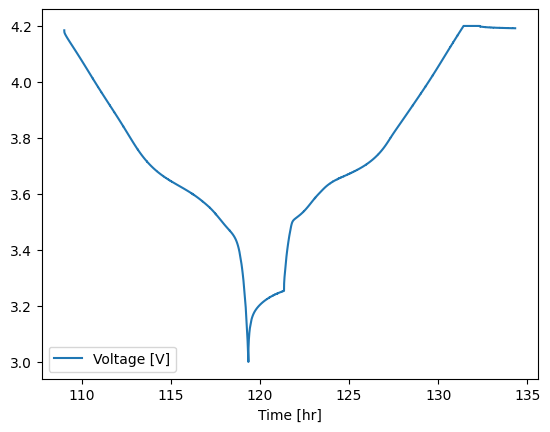

In [3]:
final_cycle = cell.procedure["Sample"].experiment("Break-in Cycles").cycle(-1)

final_cycle.plot(x="Time [hr]", y="Voltage [V]")

We can use the methods of the `differentiation` module to calculate the gradients of the data.

Text(0, 0.5, 'd(Capacity [Ah])/d(Voltage [V])')

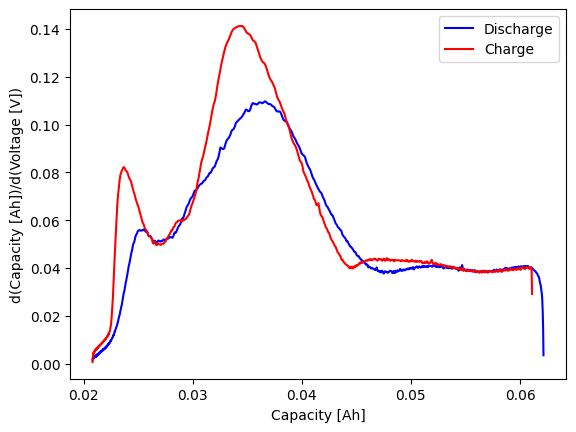

In [4]:
from pyprobe.analysis import differentiation

discharge_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.discharge(0),
    x="Capacity [Ah]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)
charge_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.charge(0).constant_current(),
    x="Capacity [Ah]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)

fig, ax = plt.subplots()
discharge_dQdV.plot(
    x="Capacity [Ah]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Discharge",
    color="blue",
)
charge_dQdV.plot(
    x="Capacity [Ah]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Charge",
    color="red",
)
ax.set_ylabel("d(Capacity [Ah])/d(Voltage [V])")

On-the-fly unit conversion allows this to be computed in whichever unit you choose:

Text(0, 0.5, 'd(Capacity [mAh])/d(Voltage [V])')

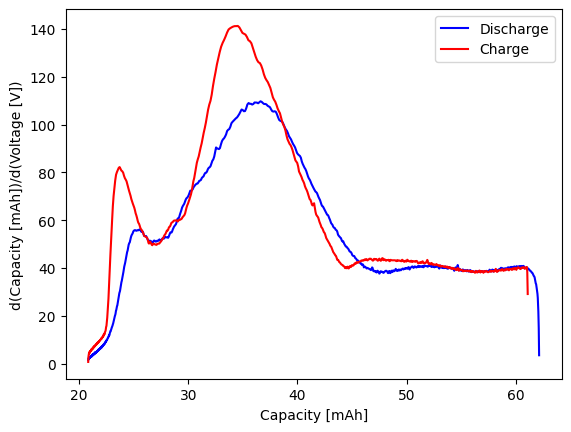

In [5]:
discharge_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.discharge(0),
    x="Capacity [mAh]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)
charge_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.charge(0).constant_current(),
    x="Capacity [mAh]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)

fig, ax = plt.subplots()
discharge_dQdV.plot(
    x="Capacity [mAh]",
    y="d(Capacity [mAh])/d(Voltage [V])",
    ax=ax,
    label="Discharge",
    color="blue",
)
charge_dQdV.plot(
    x="Capacity [mAh]",
    y="d(Capacity [mAh])/d(Voltage [V])",
    ax=ax,
    label="Charge",
    color="red",
)
ax.set_ylabel("d(Capacity [mAh])/d(Voltage [V])")

To align the curves, we can instead plot `Cycle Capacity [Ah]` which is set to zero at the beginning of the filtered cycle.

<Axes: xlabel='Cycle Capacity [Ah]'>

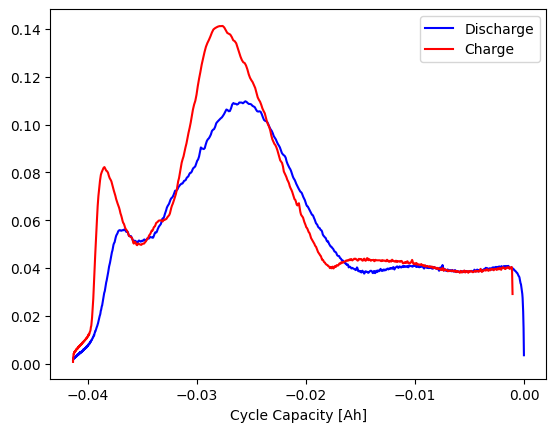

In [6]:
discharge_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.discharge(0),
    x="Cycle Capacity [Ah]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)
charge_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.charge(0).constant_current(),
    x="Cycle Capacity [Ah]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)

fig, ax = plt.subplots()
discharge_dQdV.plot(
    x="Cycle Capacity [Ah]",
    y="d(Cycle Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Discharge",
    color="blue",
)
charge_dQdV.plot(
    x="Cycle Capacity [Ah]",
    y="d(Cycle Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Charge",
    color="red",
)